In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchsummary
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")

In [2]:
N = 500
data = np.pi*(np.linspace(0, 30, N))
data

array([ 0.        ,  0.18887331,  0.37774661,  0.56661992,  0.75549322,
        0.94436653,  1.13323983,  1.32211314,  1.51098645,  1.69985975,
        1.88873306,  2.07760636,  2.26647967,  2.45535298,  2.64422628,
        2.83309959,  3.02197289,  3.2108462 ,  3.3997195 ,  3.58859281,
        3.77746612,  3.96633942,  4.15521273,  4.34408603,  4.53295934,
        4.72183265,  4.91070595,  5.09957926,  5.28845256,  5.47732587,
        5.66619917,  5.85507248,  6.04394579,  6.23281909,  6.4216924 ,
        6.6105657 ,  6.79943901,  6.98831232,  7.17718562,  7.36605893,
        7.55493223,  7.74380554,  7.93267884,  8.12155215,  8.31042546,
        8.49929876,  8.68817207,  8.87704537,  9.06591868,  9.25479199,
        9.44366529,  9.6325386 ,  9.8214119 , 10.01028521, 10.19915851,
       10.38803182, 10.57690513, 10.76577843, 10.95465174, 11.14352504,
       11.33239835, 11.52127166, 11.71014496, 11.89901827, 12.08789157,
       12.27676488, 12.46563818, 12.65451149, 12.8433848 , 13.03

In [3]:
train_data = np.sin(data + np.cos(data))
train_data = torch.tensor(train_data).float()

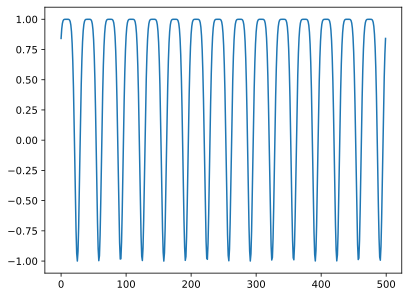

In [4]:
plt.plot(train_data)

In [5]:
input_size = 1
seq_length = 30
batch_size = 1
num_hidden = 5
num_layers = 1

In [6]:
class RNNnet(nn.Module):
    def __init__(self, input_size, num_hidden, num_layers):
        super().__init__()
        self.input_size = input_size
        self.num_hidden = num_hidden
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size, num_hidden, num_layers)
        self.out = nn.Linear(num_hidden, 1)

    def forward(self, x):
        x, h = self.rnn(x)
        x = self.out(x)
        return x, h

In [7]:
net = RNNnet(input_size, num_hidden, num_layers)
net = net.to(device="cuda:0")
torchsummary.summary(net, (batch_size, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1   [[-1, 1, 5], [-1, 1, 5]]               0
            Linear-2                 [-1, 1, 1]               6
Total params: 6
Trainable params: 6
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [8]:
net = RNNnet(input_size, num_hidden, num_layers)
x = train_data[:seq_length].view(seq_length, batch_size, input_size)
y_pred, h = net(x)
print(x.shape, y_pred.shape, h.shape)

torch.Size([30, 1, 1]) torch.Size([30, 1, 1]) torch.Size([1, 1, 5])


In [9]:
epochs = 50

net = RNNnet(input_size, num_hidden, num_layers)
optimizer = torch.optim.SGD(net.parameters(), lr=.001)
lossfunc = nn.MSELoss()
losses = np.zeros(epochs)
sign_acc = np.zeros(epochs)


for ei in range(epochs):
    seg_losses = []
    seg_acc = []

    for ti in range(N-seq_length):
        x = train_data[ti:ti+seq_length].view(seq_length, batch_size, input_size)
        y = train_data[ti+seq_length].view(batch_size, input_size)

        y_pred = net(x)
        final_val = y_pred[-1]
        loss = lossfunc(final_val, y)
        true_sign = np.sign(torch.squeeze(y).numpy())
        pred_sign = np.sign(torch.squeeze(final_val).detach().numpy())
        acc = 100*(true_sign==pred_sign)

        seg_losses.append(loss.item())
        seg_acc.append(acc)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses[ei] = np.mean(seg_losses)
    sign_acc[ei] = np.mean(seg_acc)

    print(f"Epoch:{ei+1}, Loss:{losses[ei]:.2f}, Sig_Acc:{sign_acc[ei]:.2f}")

/home/shravan/miniconda3/envs/dl/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:1, Loss:0.81, Sig_Acc:45.79
Epoch:2, Loss:0.51, Sig_Acc:67.96
Epoch:3, Loss:0.35, Sig_Acc:83.23
Epoch:4, Loss:0.26, Sig_Acc:84.21
Epoch:5, Loss:0.20, Sig_Acc:86.30
Epoch:6, Loss:0.16, Sig_Acc:90.38
Epoch:7, Loss:0.14, Sig_Acc:91.19
Epoch:8, Loss:0.12, Sig_Acc:91.19
Epoch:9, Loss:0.11, Sig_Acc:91.36
Epoch:10, Loss:0.10, Sig_Acc:91.53
Epoch:11, Loss:0.09, Sig_Acc:91.74
Epoch:12, Loss:0.09, Sig_Acc:91.91
Epoch:13, Loss:0.09, Sig_Acc:91.96
Epoch:14, Loss:0.08, Sig_Acc:92.21
Epoch:15, Loss:0.08, Sig_Acc:92.43
Epoch:16, Loss:0.08, Sig_Acc:92.55
Epoch:17, Loss:0.08, Sig_Acc:92.72
Epoch:18, Loss:0.07, Sig_Acc:92.81
Epoch:19, Loss:0.07, Sig_Acc:92.85
Epoch:20, Loss:0.07, Sig_Acc:92.98
Epoch:21, Loss:0.07, Sig_Acc:93.06
Epoch:22, Loss:0.07, Sig_Acc:93.19
Epoch:23, Loss:0.07, Sig_Acc:93.36
Epoch:24, Loss:0.06, Sig_Acc:93.36
Epoch:25, Loss:0.06, Sig_Acc:93.49
Epoch:26, Loss:0.06, Sig_Acc:93.62
Epoch:27, Loss:0.06, Sig_Acc:93.70
Epoch:28, Loss:0.06, Sig_Acc:93.79
Epoch:29, Loss:0.06, Sig_Acc:

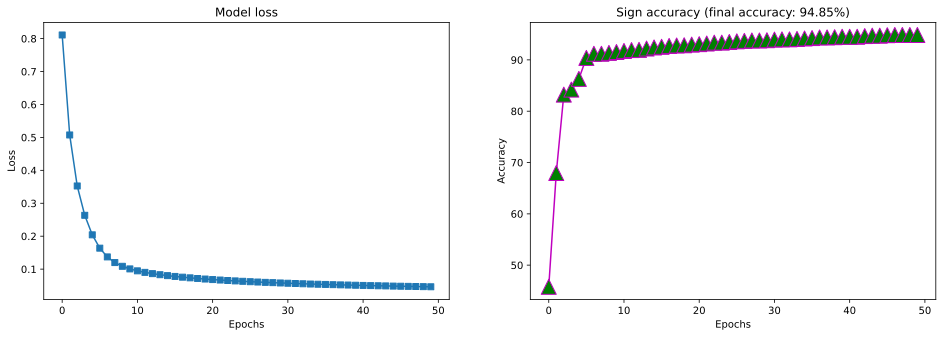

In [10]:
## let's see how the model did!

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(sign_acc,'m^-',markerfacecolor='g',markersize=15)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Sign accuracy (final accuracy: %.2f%%)'%sign_acc[-1])

plt.show()

In [11]:
epochs = 50

net = RNNnet(input_size, num_hidden, num_layers)
net.to(device="cuda:0")
optimizer = torch.optim.SGD(net.parameters(), lr=.001)
lossfunc = nn.MSELoss()
losses = np.zeros(epochs)
sign_acc = np.zeros(epochs)


for ei in range(epochs):
    seg_losses = []
    seg_acc = []

    for ti in range(N-seq_length):
        x = train_data[ti:ti+seq_length].view(seq_length, batch_size, input_size)
        x = x.to(device="cuda:0")
        y = train_data[ti+seq_length].view(batch_size, input_size)
        y = y.to(device="cuda:0")

        y_pred = net(x)
        final_val = y_pred[-1]
        loss = lossfunc(final_val, y)
        true_sign = np.sign(torch.squeeze(y).cpu().numpy())
        pred_sign = np.sign(torch.squeeze(final_val).detach().cpu().numpy())
        acc = 100*(true_sign==pred_sign)

        seg_losses.append(loss.item())
        seg_acc.append(acc)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses[ei] = np.mean(seg_losses)
    sign_acc[ei] = np.mean(seg_acc)

    print(f"Epoch:{ei+1}, Loss:{losses[ei]:.2f}, Sign_Acc:{sign_acc[ei]:.2f}")

Epoch:1, Loss:0.51, Sign_Acc:75.28
Epoch:2, Loss:0.39, Sign_Acc:84.09
Epoch:3, Loss:0.33, Sign_Acc:86.09
Epoch:4, Loss:0.28, Sign_Acc:86.72
Epoch:5, Loss:0.24, Sign_Acc:87.23
Epoch:6, Loss:0.22, Sign_Acc:87.57
Epoch:7, Loss:0.20, Sign_Acc:87.70
Epoch:8, Loss:0.18, Sign_Acc:87.96
Epoch:9, Loss:0.16, Sign_Acc:88.04
Epoch:10, Loss:0.15, Sign_Acc:87.96
Epoch:11, Loss:0.13, Sign_Acc:87.96
Epoch:12, Loss:0.12, Sign_Acc:87.91
Epoch:13, Loss:0.11, Sign_Acc:88.21
Epoch:14, Loss:0.10, Sign_Acc:90.09
Epoch:15, Loss:0.10, Sign_Acc:90.94
Epoch:16, Loss:0.09, Sign_Acc:91.45
Epoch:17, Loss:0.09, Sign_Acc:91.91
Epoch:18, Loss:0.08, Sign_Acc:91.91
Epoch:19, Loss:0.08, Sign_Acc:92.13
Epoch:20, Loss:0.08, Sign_Acc:92.13
Epoch:21, Loss:0.07, Sign_Acc:92.26
Epoch:22, Loss:0.07, Sign_Acc:92.34
Epoch:23, Loss:0.07, Sign_Acc:92.43
Epoch:24, Loss:0.07, Sign_Acc:92.55
Epoch:25, Loss:0.07, Sign_Acc:92.68
Epoch:26, Loss:0.06, Sign_Acc:92.77
Epoch:27, Loss:0.06, Sign_Acc:92.89
Epoch:28, Loss:0.06, Sign_Acc:92.94
E

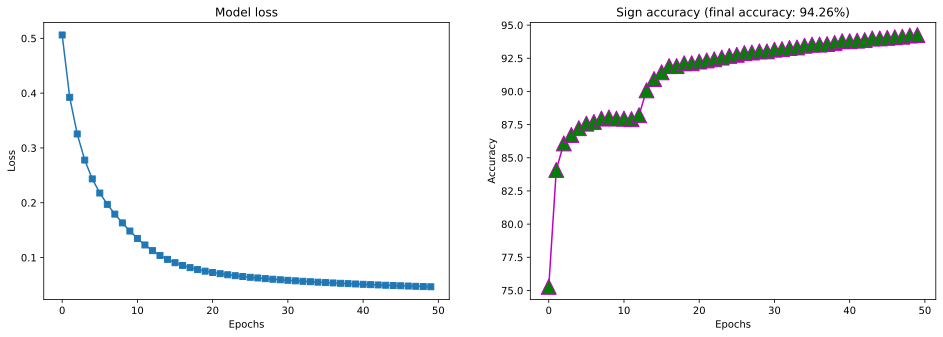

In [12]:
## let's see how the model did!

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(sign_acc,'m^-',markerfacecolor='g',markersize=15)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Sign accuracy (final accuracy: %.2f%%)'%sign_acc[-1])

plt.show()

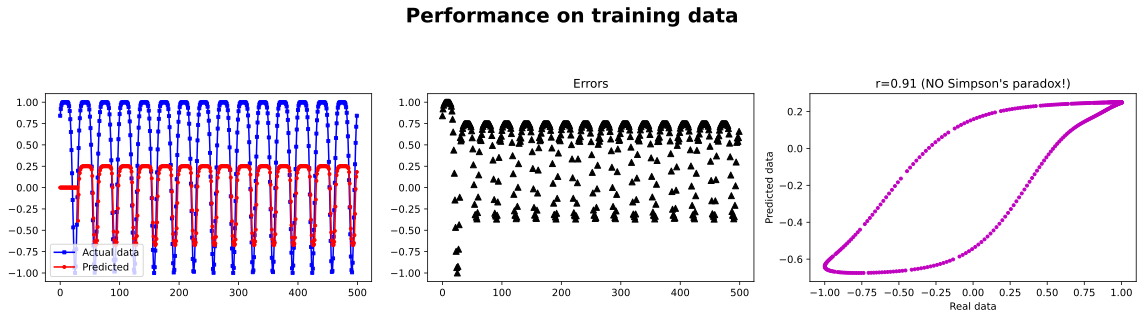

In [13]:
# now test the network!

h = np.zeros((N,num_hidden))

yHat = np.zeros(N)
for timei in range(N-seq_length):

  # grab a snippet of data
  X = train_data[timei:timei+seq_length].view(seq_length,1,1)
  X = X.to(device="cuda:0")

  # forward pass and loss
  yy,hh = net(X)
  yHat[timei+seq_length] = yy[-1].cpu()
  h[timei+seq_length,:] = hh.cpu().detach()


## plot!
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(train_data,'bs-',label='Actual data',markersize=3)
ax[0].plot(yHat,'ro-',label='Predicted',markersize=3)
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(train_data-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Errors')

ax[2].plot(train_data[seq_length:],yHat[seq_length:],'mo',markersize=3)
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(train_data[seq_length:],yHat[seq_length:])
ax[2].set_title(f"r={r[0,1]:.2f} (NO Simpson's paradox!)")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

## Test with New Data

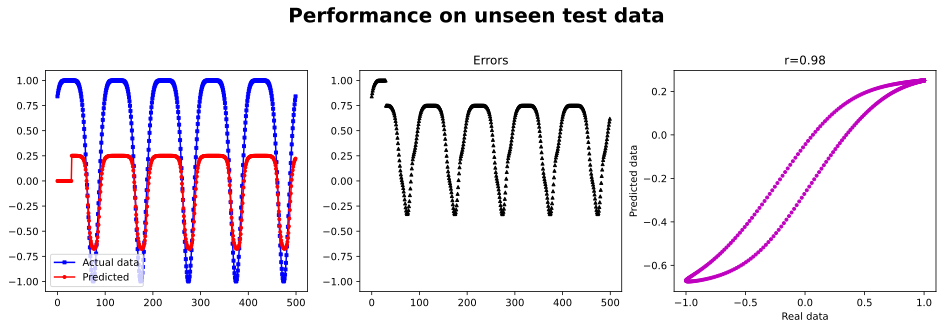

In [14]:
## Create new data (orange case: different frequency)
time = torch.linspace(0,10*np.pi,N)
newdata = torch.sin(time+torch.cos(time))



# loop over time and predict each subsequent value
yHat = np.zeros(N)
for timei in range(N-seq_length):

  # grab a snippet of data
  X = newdata[timei:timei+seq_length].view(seq_length,1,1)
  X = X.to(device="cuda:0")

  # forward pass and loss (don't need hidden states here)
  yy,h = net(X)
  yHat[timei+seq_length] = yy[-1].cpu()


# plotting
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(newdata,'bs-',label='Actual data',markersize=3)
ax[0].plot(yHat,'ro-',label='Predicted',markersize=3)
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(newdata-yHat,'k^',markersize=3)
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Errors')

ax[2].plot(newdata[seq_length:],yHat[seq_length:],'mo',markersize=3)
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(newdata[seq_length:],yHat[seq_length:])
ax[2].set_title(f"r={r[0,1]:.2f}")

plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20,y=1.1)
plt.show()

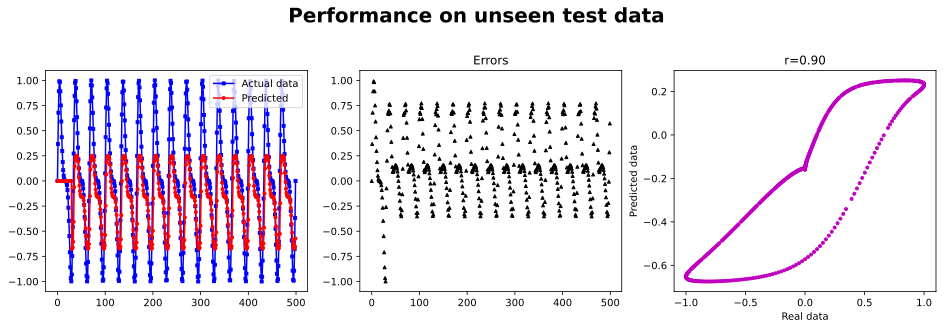

In [15]:
# Create new data (red case: different function)
time = torch.linspace(0,30*np.pi,N)
newdata = torch.sin(time+torch.sin(time))



# loop over time and predict each subsequent value
yHat = np.zeros(N)
for timei in range(N-seq_length):

  # grab a snippet of data
  X = newdata[timei:timei+seq_length].view(seq_length,1,1)
  X = X.to(device="cuda:0")

  # forward pass and loss (don't need hidden states here)
  yy,h = net(X)
  yHat[timei+seq_length] = yy[-1].cpu()


# plotting
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(newdata,'bs-',label='Actual data',markersize=3)
ax[0].plot(yHat,'ro-',label='Predicted',markersize=3)
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(newdata-yHat,'k^',markersize=3)
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Errors')

ax[2].plot(newdata[seq_length:],yHat[seq_length:],'mo',markersize=3)
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(newdata[seq_length:],yHat[seq_length:])
ax[2].set_title(f"r={r[0,1]:.2f}")

plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20,y=1.1)
plt.show()

# Longer-term extrapolation

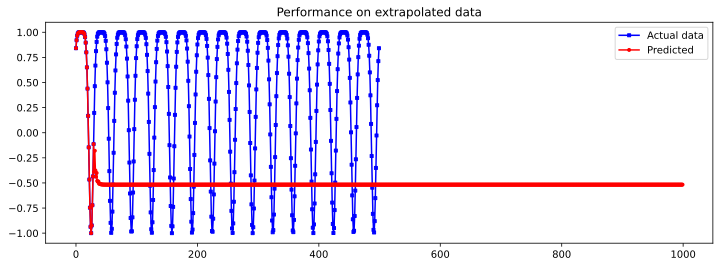

In [16]:
# using original data

# create a signal 2x as long
yHat = torch.zeros(2*N) # torch, not np!
yHat[:N] = train_data

for timei in range(2*N-seq_length):

  # grab a snippet of data
  X = yHat[timei:timei+seq_length].view(seq_length,1,1)
  X = X.to(device="cuda:0")
  
  # forward pass and loss
  yy,h = net(X)
  yHat[timei+seq_length] = yy[-1]



# convert back to np for plotting
yHat = yHat.cpu().detach()

# plotting
fig = plt.figure(figsize=(12,4))
plt.plot(train_data,'bs-',label='Actual data',markersize=3)
plt.plot(yHat,'ro-',label='Predicted',markersize=3)
plt.ylim([-1.1,1.1])
plt.legend()
plt.title('Performance on extrapolated data')
plt.show()